In [1]:
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.utils as vutils
import torchvision.models as models
from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

import matplotlib.pyplot as plt
import numpy as np
import random
import os
import time

In [2]:
# Root directory for dataset
dataroot = "/content/lego-faces"


np.random.seed(1234)
torch.manual_seed(1234)
random.seed(1234)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

BATCH_SIZE  = 64
N_EPOCHS = 300
IMAGE_SIZE = 64
LATENT_DIM = 100

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

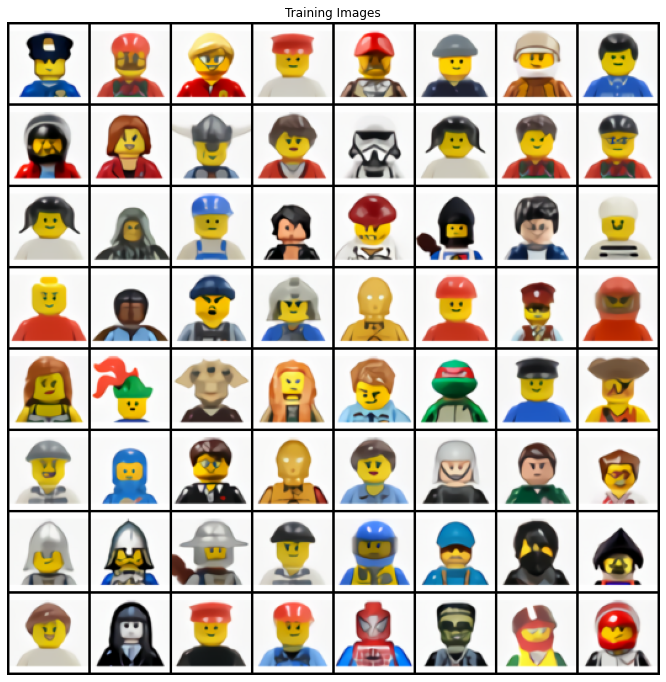

In [3]:
# Create the dataset
dataset = datasets.ImageFolder(root=dataroot,
                               transform=transforms.Compose([
                                   transforms.Resize(IMAGE_SIZE),
                                   transforms.CenterCrop(IMAGE_SIZE),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                               ]))

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                         shuffle=True)

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(12, 12))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(), (1, 2, 0)))

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim, image_size):
        super().__init__()
        
        self.main = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels=latent_dim, 
                               out_channels=image_size*8, 
                               kernel_size=4,
                               stride=1,
                               padding=0,
                               bias=False),
            nn.BatchNorm2d(image_size*8),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=image_size*8, 
                               out_channels=image_size*4, 
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(image_size*4),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=image_size*4, 
                               out_channels=image_size*2, 
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(image_size*2),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=image_size*2, 
                               out_channels=image_size, 
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            nn.BatchNorm2d(image_size),
            nn.ReLU(inplace=True),
            
            nn.ConvTranspose2d(in_channels=image_size, 
                               out_channels=3, 
                               kernel_size=4,
                               stride=2,
                               padding=1,
                               bias=False),
            
            nn.Tanh(),
        )
        
    def forward(self, x):
        return self.main(x)

G = Generator(LATENT_DIM, IMAGE_SIZE).to(device)
G.apply(weights_init)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)

In [6]:
class Discriminator(nn.Module):
    def __init__(self, image_size):
        super().__init__()
        
        self.main = nn.Sequential(
        
            nn.Conv2d(in_channels=3,
                      out_channels=image_size,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=image_size,
                      out_channels=image_size*2,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(image_size*2),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=image_size*2,
                      out_channels=image_size*4,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(image_size*4),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=image_size*4,
                      out_channels=image_size*8,
                      kernel_size=4,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.BatchNorm2d(image_size*8),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Conv2d(in_channels=image_size*8,
                      out_channels=1,
                      kernel_size=4,
                      stride=1,
                      padding=0,
                      bias=False),
            
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        return self.main(x).view(-1, 1).squeeze(1)
    
    
D = Discriminator(IMAGE_SIZE).to(device)
D.apply(weights_init)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [7]:
criterion = nn.BCELoss()

G_optimizer = optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
D_optimizer = optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))

#labels
real_labels = torch.ones(BATCH_SIZE,).to(device)
fake_labels = torch.zeros(BATCH_SIZE,).to(device)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [8]:
class InceptionV3(nn.Module):
    """Pretrained InceptionV3 network returning feature maps"""

    # Index of default block of inception to return,
    # corresponds to output of final average pooling
    DEFAULT_BLOCK_INDEX = 3

    # Maps feature dimensionality to their output blocks indices
    BLOCK_INDEX_BY_DIM = {
        64: 0,   # First max pooling features
        192: 1,  # Second max pooling featurs
        768: 2,  # Pre-aux classifier features
        2048: 3  # Final average pooling features
    }

    def __init__(self,
                 output_blocks=[DEFAULT_BLOCK_INDEX],
                 resize_input=True,
                 normalize_input=True,
                 requires_grad=False):
        
        super(InceptionV3, self).__init__()

        self.resize_input = resize_input
        self.normalize_input = normalize_input
        self.output_blocks = sorted(output_blocks)
        self.last_needed_block = max(output_blocks)

        assert self.last_needed_block <= 3, \
            'Last possible output block index is 3'

        self.blocks = nn.ModuleList()

        
        inception = models.inception_v3(pretrained=True)

        # Block 0: input to maxpool1
        block0 = [
            inception.Conv2d_1a_3x3,
            inception.Conv2d_2a_3x3,
            inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2)
        ]
        self.blocks.append(nn.Sequential(*block0))

        # Block 1: maxpool1 to maxpool2
        if self.last_needed_block >= 1:
            block1 = [
                inception.Conv2d_3b_1x1,
                inception.Conv2d_4a_3x3,
                nn.MaxPool2d(kernel_size=3, stride=2)
            ]
            self.blocks.append(nn.Sequential(*block1))

        # Block 2: maxpool2 to aux classifier
        if self.last_needed_block >= 2:
            block2 = [
                inception.Mixed_5b,
                inception.Mixed_5c,
                inception.Mixed_5d,
                inception.Mixed_6a,
                inception.Mixed_6b,
                inception.Mixed_6c,
                inception.Mixed_6d,
                inception.Mixed_6e,
            ]
            self.blocks.append(nn.Sequential(*block2))

        # Block 3: aux classifier to final avgpool
        if self.last_needed_block >= 3:
            block3 = [
                inception.Mixed_7a,
                inception.Mixed_7b,
                inception.Mixed_7c,
                nn.AdaptiveAvgPool2d(output_size=(1, 1))
            ]
            self.blocks.append(nn.Sequential(*block3))

        for param in self.parameters():
            param.requires_grad = requires_grad

    def forward(self, inp):
        """Get Inception feature maps
        Parameters
        ----------
        inp : torch.autograd.Variable
            Input tensor of shape Bx3xHxW. Values are expected to be in
            range (0, 1)
        Returns
        -------
        List of torch.autograd.Variable, corresponding to the selected output
        block, sorted ascending by index
        """
        outp = []
        x = inp

        if self.resize_input:
            x = F.interpolate(x,
                              size=(299, 299),
                              mode='bilinear',
                              align_corners=False)

        if self.normalize_input:
            x = 2 * x - 1  # Scale from range (0, 1) to range (-1, 1)

        for idx, block in enumerate(self.blocks):
            x = block(x)
            if idx in self.output_blocks:
                outp.append(x)

            if idx == self.last_needed_block:
                break

        return outp
    
block_idx = InceptionV3.BLOCK_INDEX_BY_DIM[2048]
model = InceptionV3([block_idx])
model=model.cuda()

In [9]:
def calculate_activation_statistics(images,model,batch_size=128, dims=2048,
                    cuda=False):
    model.eval()
    act=np.empty((len(images), dims))
    
    if cuda:
        batch=images.cuda()
    else:
        batch=images
    pred = model(batch)[0]

        # If model output is not scalar, apply global spatial average pooling.
        # This happens if you choose a dimensionality not equal 2048.
    if pred.size(2) != 1 or pred.size(3) != 1:
        pred = adaptive_avg_pool2d(pred, output_size=(1, 1))

    act= pred.cpu().data.numpy().reshape(pred.size(0), -1)
    
    mu = np.mean(act, axis=0)
    sigma = np.cov(act, rowvar=False)
    return mu, sigma

def calculate_frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """Numpy implementation of the Frechet Distance.
    The Frechet distance between two multivariate Gaussians X_1 ~ N(mu_1, C_1)
    and X_2 ~ N(mu_2, C_2) is
            d^2 = ||mu_1 - mu_2||^2 + Tr(C_1 + C_2 - 2*sqrt(C_1*C_2)).
    """

    mu1 = np.atleast_1d(mu1)
    mu2 = np.atleast_1d(mu2)

    sigma1 = np.atleast_2d(sigma1)
    sigma2 = np.atleast_2d(sigma2)

    assert mu1.shape == mu2.shape, \
        'Training and test mean vectors have different lengths'
    assert sigma1.shape == sigma2.shape, \
        'Training and test covariances have different dimensions'

    diff = mu1 - mu2

    
    covmean, _ = linalg.sqrtm(sigma1.dot(sigma2), disp=False)
    if not np.isfinite(covmean).all():
        msg = ('fid calculation produces singular product; '
               'adding %s to diagonal of cov estimates') % eps
        print(msg)
        offset = np.eye(sigma1.shape[0]) * eps
        covmean = linalg.sqrtm((sigma1 + offset).dot(sigma2 + offset))

    
    if np.iscomplexobj(covmean):
        if not np.allclose(np.diagonal(covmean).imag, 0, atol=1e-3):
            m = np.max(np.abs(covmean.imag))
        covmean = covmean.real

    tr_covmean = np.trace(covmean)

    return (diff.dot(diff) + np.trace(sigma1) +
            np.trace(sigma2) - 2 * tr_covmean)

def calculate_fretchet(images_real,images_fake,model):
     mu_1,std_1=calculate_activation_statistics(images_real,model,cuda=True)
     mu_2,std_2=calculate_activation_statistics(images_fake,model,cuda=True)
    
     """get fretched distance"""
     fid_value = calculate_frechet_distance(mu_1, std_1, mu_2, std_2)
     return fid_value

| Epoch: 000 | D_error: 0.079 | G_error: 7.557 | FID_score: 386.2661 | Time: 0m 16s


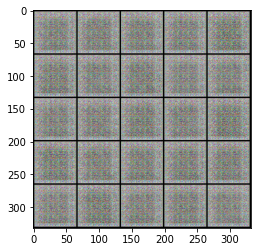

| Epoch: 1 |
| Epoch: 2 |
| Epoch: 3 |
| Epoch: 4 |
| Epoch: 005 | D_error: 0.760 | G_error: 7.009 | FID_score: 391.9210 | Time: 0m 16s


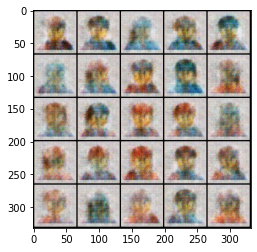

| Epoch: 6 |
| Epoch: 7 |
| Epoch: 8 |
| Epoch: 9 |
| Epoch: 010 | D_error: 0.490 | G_error: 2.044 | FID_score: 373.4699 | Time: 0m 16s


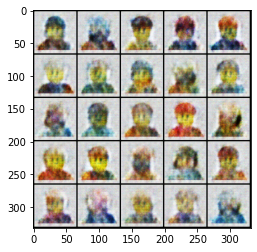

| Epoch: 11 |
| Epoch: 12 |
| Epoch: 13 |
| Epoch: 14 |
| Epoch: 015 | D_error: 0.404 | G_error: 4.512 | FID_score: 359.6885 | Time: 0m 16s


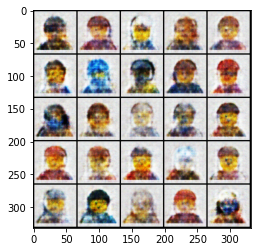

| Epoch: 16 |
| Epoch: 17 |
| Epoch: 18 |
| Epoch: 19 |
| Epoch: 020 | D_error: 0.253 | G_error: 2.723 | FID_score: 358.4719 | Time: 0m 16s


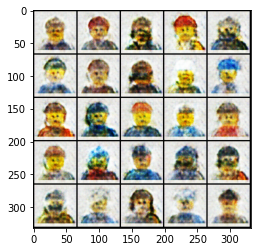

| Epoch: 21 |
| Epoch: 22 |
| Epoch: 23 |
| Epoch: 24 |
| Epoch: 025 | D_error: 0.344 | G_error: 3.619 | FID_score: 317.2967 | Time: 0m 16s


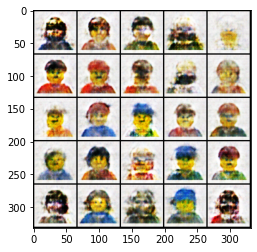

| Epoch: 26 |
| Epoch: 27 |
| Epoch: 28 |
| Epoch: 29 |
| Epoch: 030 | D_error: 0.368 | G_error: 2.914 | FID_score: 302.8155 | Time: 0m 16s


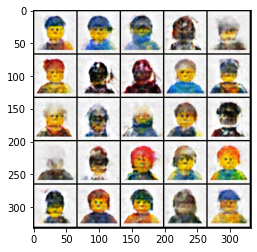

| Epoch: 31 |
| Epoch: 32 |
| Epoch: 33 |
| Epoch: 34 |
| Epoch: 035 | D_error: 0.464 | G_error: 3.829 | FID_score: 313.5515 | Time: 0m 16s


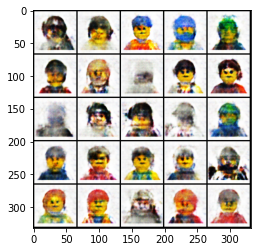

| Epoch: 36 |
| Epoch: 37 |
| Epoch: 38 |
| Epoch: 39 |
| Epoch: 040 | D_error: 0.306 | G_error: 4.391 | FID_score: 284.5005 | Time: 0m 16s


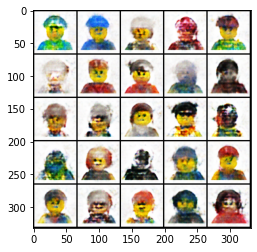

| Epoch: 41 |
| Epoch: 42 |
| Epoch: 43 |
| Epoch: 44 |
| Epoch: 045 | D_error: 0.288 | G_error: 2.772 | FID_score: 290.2884 | Time: 0m 16s


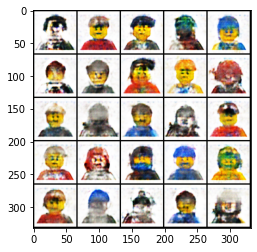

| Epoch: 46 |
| Epoch: 47 |
| Epoch: 48 |
| Epoch: 49 |
| Epoch: 050 | D_error: 0.212 | G_error: 3.178 | FID_score: 271.1198 | Time: 0m 16s


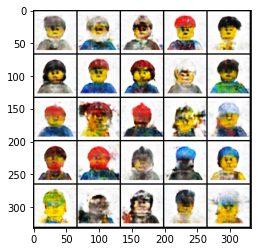

| Epoch: 51 |
| Epoch: 52 |
| Epoch: 53 |
| Epoch: 54 |
| Epoch: 055 | D_error: 0.299 | G_error: 1.463 | FID_score: 266.7807 | Time: 0m 16s


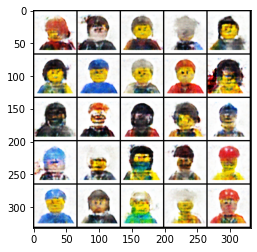

| Epoch: 56 |
| Epoch: 57 |
| Epoch: 58 |
| Epoch: 59 |
| Epoch: 060 | D_error: 0.363 | G_error: 1.101 | FID_score: 261.8007 | Time: 0m 16s


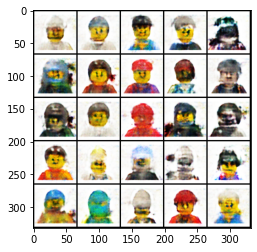

| Epoch: 61 |
| Epoch: 62 |
| Epoch: 63 |
| Epoch: 64 |
| Epoch: 065 | D_error: 0.216 | G_error: 2.804 | FID_score: 264.3105 | Time: 0m 16s


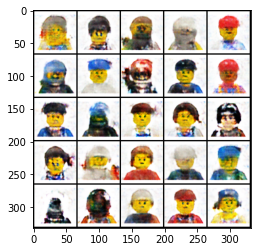

| Epoch: 66 |
| Epoch: 67 |
| Epoch: 68 |
| Epoch: 69 |
| Epoch: 070 | D_error: 1.393 | G_error: 1.186 | FID_score: 261.6150 | Time: 0m 16s


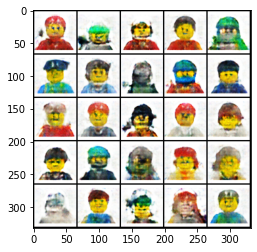

| Epoch: 71 |
| Epoch: 72 |
| Epoch: 73 |
| Epoch: 74 |
| Epoch: 075 | D_error: 0.119 | G_error: 3.918 | FID_score: 263.2278 | Time: 0m 16s


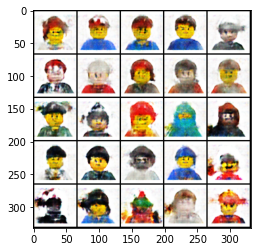

| Epoch: 76 |
| Epoch: 77 |
| Epoch: 78 |
| Epoch: 79 |
| Epoch: 080 | D_error: 0.237 | G_error: 4.815 | FID_score: 273.4767 | Time: 0m 16s


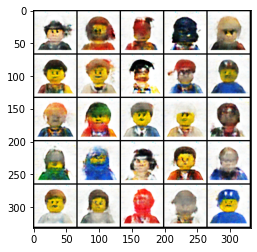

| Epoch: 81 |
| Epoch: 82 |
| Epoch: 83 |
| Epoch: 84 |
| Epoch: 085 | D_error: 0.155 | G_error: 3.999 | FID_score: 247.6064 | Time: 0m 16s


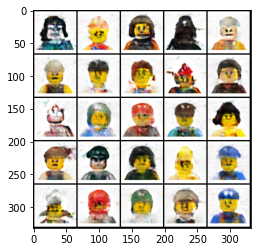

| Epoch: 86 |
| Epoch: 87 |
| Epoch: 88 |
| Epoch: 89 |
| Epoch: 090 | D_error: 0.117 | G_error: 4.466 | FID_score: 255.1015 | Time: 0m 16s


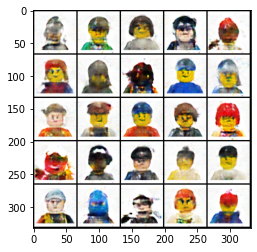

| Epoch: 91 |
| Epoch: 92 |
| Epoch: 93 |
| Epoch: 94 |
| Epoch: 095 | D_error: 0.072 | G_error: 3.402 | FID_score: 263.4840 | Time: 0m 16s


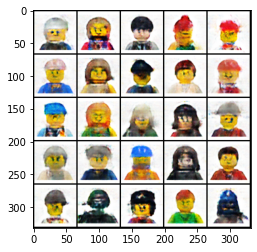

| Epoch: 96 |
| Epoch: 97 |
| Epoch: 98 |
| Epoch: 99 |
| Epoch: 100 | D_error: 0.122 | G_error: 3.876 | FID_score: 267.5857 | Time: 0m 16s


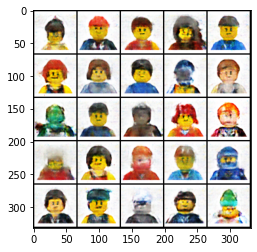

| Epoch: 101 |
| Epoch: 102 |
| Epoch: 103 |
| Epoch: 104 |
| Epoch: 105 | D_error: 0.322 | G_error: 2.362 | FID_score: 279.2002 | Time: 0m 16s


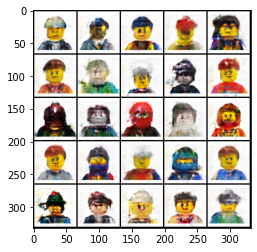

| Epoch: 106 |
| Epoch: 107 |
| Epoch: 108 |
| Epoch: 109 |
| Epoch: 110 | D_error: 0.093 | G_error: 3.550 | FID_score: 253.4256 | Time: 0m 16s


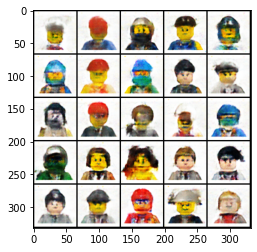

| Epoch: 111 |
| Epoch: 112 |
| Epoch: 113 |
| Epoch: 114 |
| Epoch: 115 | D_error: 0.102 | G_error: 3.879 | FID_score: 286.2350 | Time: 0m 16s


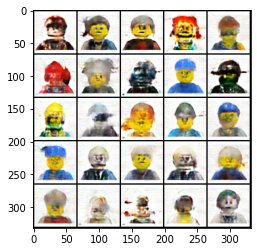

| Epoch: 116 |
| Epoch: 117 |
| Epoch: 118 |
| Epoch: 119 |
| Epoch: 120 | D_error: 0.053 | G_error: 4.128 | FID_score: 277.5865 | Time: 0m 16s


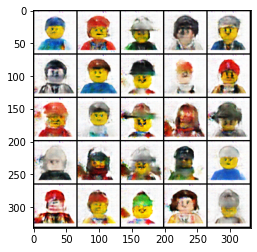

| Epoch: 121 |
| Epoch: 122 |
| Epoch: 123 |
| Epoch: 124 |
| Epoch: 125 | D_error: 0.070 | G_error: 4.233 | FID_score: 256.0423 | Time: 0m 16s


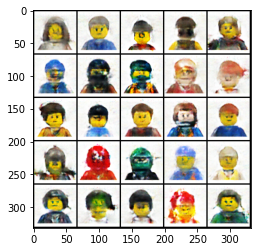

| Epoch: 126 |
| Epoch: 127 |
| Epoch: 128 |
| Epoch: 129 |
| Epoch: 130 | D_error: 0.037 | G_error: 3.815 | FID_score: 260.8314 | Time: 0m 16s


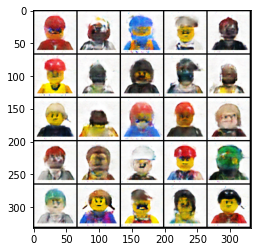

| Epoch: 131 |
| Epoch: 132 |
| Epoch: 133 |
| Epoch: 134 |
| Epoch: 135 | D_error: 0.150 | G_error: 4.816 | FID_score: 283.9034 | Time: 0m 16s


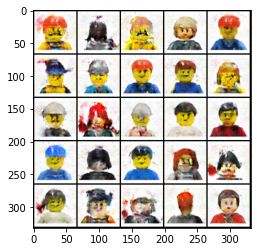

| Epoch: 136 |
| Epoch: 137 |
| Epoch: 138 |
| Epoch: 139 |
| Epoch: 140 | D_error: 0.054 | G_error: 4.644 | FID_score: 255.3000 | Time: 0m 15s


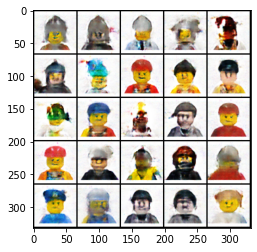

| Epoch: 141 |
| Epoch: 142 |
| Epoch: 143 |
| Epoch: 144 |
| Epoch: 145 | D_error: 0.156 | G_error: 5.393 | FID_score: 266.6913 | Time: 0m 16s


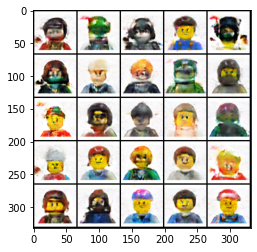

| Epoch: 146 |
| Epoch: 147 |
| Epoch: 148 |
| Epoch: 149 |
| Epoch: 150 | D_error: 0.098 | G_error: 4.063 | FID_score: 286.1460 | Time: 0m 16s


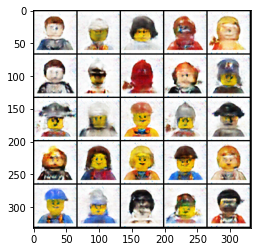

| Epoch: 151 |
| Epoch: 152 |
| Epoch: 153 |
| Epoch: 154 |
| Epoch: 155 | D_error: 0.042 | G_error: 4.120 | FID_score: 268.5459 | Time: 0m 16s


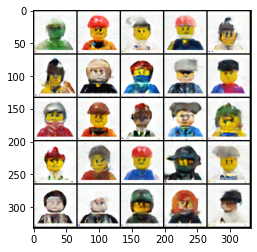

| Epoch: 156 |
| Epoch: 157 |
| Epoch: 158 |
| Epoch: 159 |
| Epoch: 160 | D_error: 0.101 | G_error: 6.156 | FID_score: 251.9153 | Time: 0m 16s


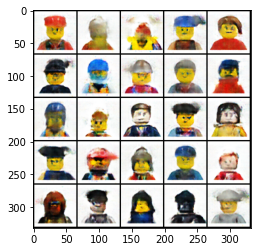

| Epoch: 161 |
| Epoch: 162 |
| Epoch: 163 |
| Epoch: 164 |
| Epoch: 165 | D_error: 0.069 | G_error: 3.939 | FID_score: 275.7545 | Time: 0m 15s


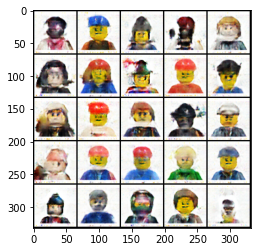

| Epoch: 166 |
| Epoch: 167 |
| Epoch: 168 |
| Epoch: 169 |
| Epoch: 170 | D_error: 0.248 | G_error: 3.772 | FID_score: 270.6102 | Time: 0m 15s


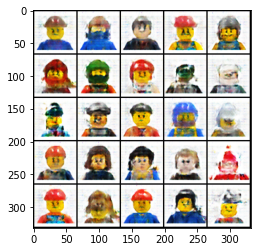

| Epoch: 171 |
| Epoch: 172 |
| Epoch: 173 |
| Epoch: 174 |
| Epoch: 175 | D_error: 0.053 | G_error: 4.002 | FID_score: 280.2780 | Time: 0m 15s


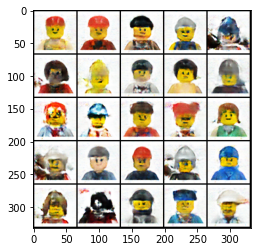

| Epoch: 176 |
| Epoch: 177 |
| Epoch: 178 |
| Epoch: 179 |
| Epoch: 180 | D_error: 0.039 | G_error: 4.957 | FID_score: 272.5591 | Time: 0m 16s


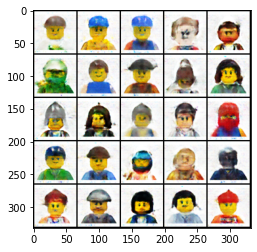

| Epoch: 181 |
| Epoch: 182 |
| Epoch: 183 |
| Epoch: 184 |
| Epoch: 185 | D_error: 0.027 | G_error: 4.975 | FID_score: 248.8812 | Time: 0m 15s


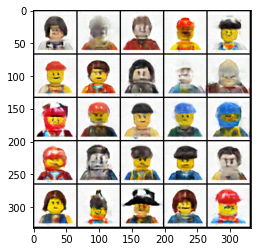

| Epoch: 186 |
| Epoch: 187 |
| Epoch: 188 |
| Epoch: 189 |
| Epoch: 190 | D_error: 0.019 | G_error: 5.057 | FID_score: 237.4225 | Time: 0m 16s


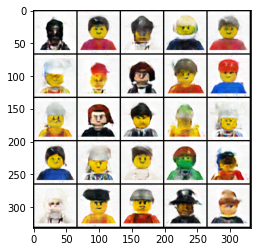

| Epoch: 191 |
| Epoch: 192 |
| Epoch: 193 |
| Epoch: 194 |
| Epoch: 195 | D_error: 1.076 | G_error: 2.921 | FID_score: 232.8979 | Time: 0m 16s


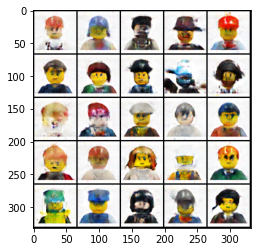

| Epoch: 196 |
| Epoch: 197 |
| Epoch: 198 |
| Epoch: 199 |
| Epoch: 200 | D_error: 0.064 | G_error: 3.551 | FID_score: 260.4985 | Time: 0m 16s


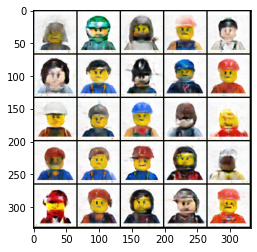

| Epoch: 201 |
| Epoch: 202 |
| Epoch: 203 |
| Epoch: 204 |
| Epoch: 205 | D_error: 0.058 | G_error: 4.250 | FID_score: 288.5388 | Time: 0m 16s


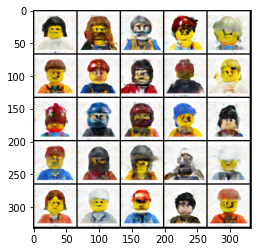

| Epoch: 206 |
| Epoch: 207 |
| Epoch: 208 |
| Epoch: 209 |
| Epoch: 210 | D_error: 0.026 | G_error: 4.550 | FID_score: 249.9450 | Time: 0m 16s


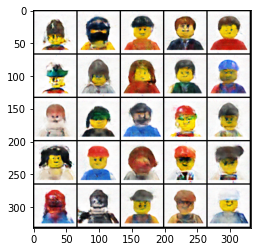

| Epoch: 211 |
| Epoch: 212 |
| Epoch: 213 |
| Epoch: 214 |
| Epoch: 215 | D_error: 0.042 | G_error: 5.266 | FID_score: 251.5369 | Time: 0m 16s


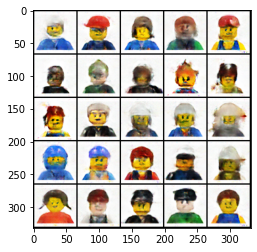

| Epoch: 216 |
| Epoch: 217 |
| Epoch: 218 |
| Epoch: 219 |
| Epoch: 220 | D_error: 0.018 | G_error: 5.384 | FID_score: 246.4506 | Time: 0m 16s


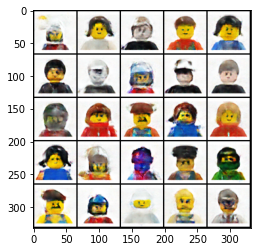

| Epoch: 221 |
| Epoch: 222 |
| Epoch: 223 |
| Epoch: 224 |
| Epoch: 225 | D_error: 0.014 | G_error: 5.500 | FID_score: 235.1506 | Time: 0m 16s


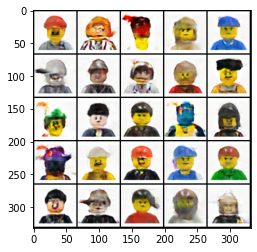

| Epoch: 226 |
| Epoch: 227 |
| Epoch: 228 |
| Epoch: 229 |
| Epoch: 230 | D_error: 1.521 | G_error: 0.454 | FID_score: 239.9968 | Time: 0m 16s


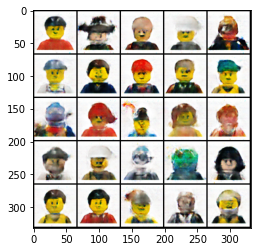

| Epoch: 231 |
| Epoch: 232 |
| Epoch: 233 |
| Epoch: 234 |
| Epoch: 235 | D_error: 0.560 | G_error: 6.545 | FID_score: 290.4811 | Time: 0m 16s


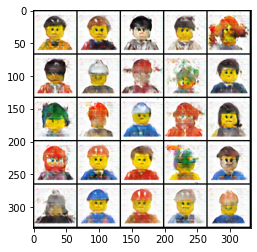

| Epoch: 236 |
| Epoch: 237 |
| Epoch: 238 |
| Epoch: 239 |
| Epoch: 240 | D_error: 0.083 | G_error: 4.900 | FID_score: 292.2191 | Time: 0m 16s


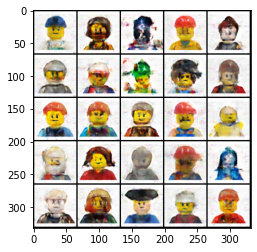

| Epoch: 241 |
| Epoch: 242 |
| Epoch: 243 |
| Epoch: 244 |
| Epoch: 245 | D_error: 1.320 | G_error: 0.180 | FID_score: 264.1810 | Time: 0m 16s


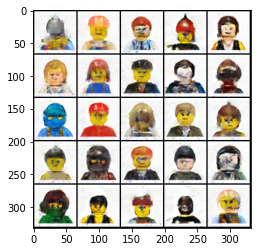

| Epoch: 246 |
| Epoch: 247 |
| Epoch: 248 |
| Epoch: 249 |
| Epoch: 250 | D_error: 0.053 | G_error: 5.779 | FID_score: 261.7771 | Time: 0m 16s


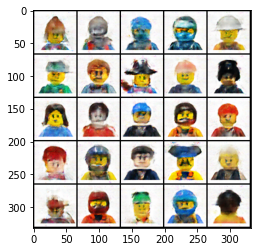

| Epoch: 251 |
| Epoch: 252 |
| Epoch: 253 |
| Epoch: 254 |
| Epoch: 255 | D_error: 0.026 | G_error: 5.308 | FID_score: 267.1658 | Time: 0m 15s


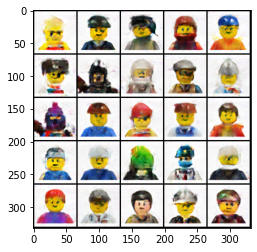

| Epoch: 256 |
| Epoch: 257 |
| Epoch: 258 |
| Epoch: 259 |
| Epoch: 260 | D_error: 0.016 | G_error: 6.331 | FID_score: 270.1637 | Time: 0m 16s


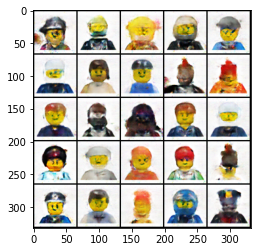

| Epoch: 261 |
| Epoch: 262 |
| Epoch: 263 |
| Epoch: 264 |
| Epoch: 265 | D_error: 0.066 | G_error: 5.421 | FID_score: 316.9399 | Time: 0m 15s


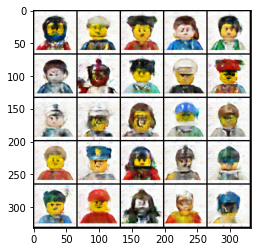

| Epoch: 266 |
| Epoch: 267 |
| Epoch: 268 |
| Epoch: 269 |
| Epoch: 270 | D_error: 0.014 | G_error: 6.108 | FID_score: 289.8316 | Time: 0m 15s


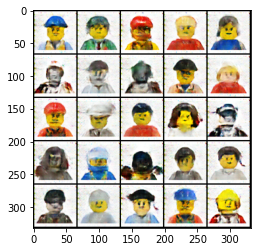

| Epoch: 271 |
| Epoch: 272 |
| Epoch: 273 |
| Epoch: 274 |
| Epoch: 275 | D_error: 0.028 | G_error: 6.049 | FID_score: 291.0862 | Time: 0m 16s


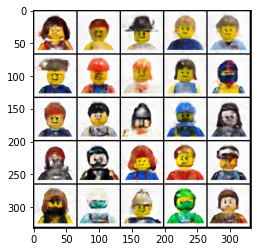

| Epoch: 276 |
| Epoch: 277 |
| Epoch: 278 |
| Epoch: 279 |
| Epoch: 280 | D_error: 0.013 | G_error: 5.772 | FID_score: 273.7877 | Time: 0m 16s


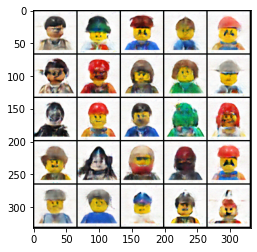

| Epoch: 281 |
| Epoch: 282 |
| Epoch: 283 |
| Epoch: 284 |
| Epoch: 285 | D_error: 0.016 | G_error: 6.270 | FID_score: 259.2013 | Time: 0m 16s


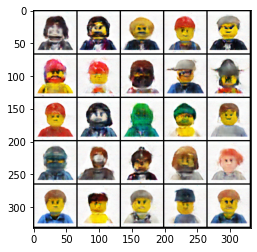

| Epoch: 286 |
| Epoch: 287 |
| Epoch: 288 |
| Epoch: 289 |
| Epoch: 290 | D_error: 0.009 | G_error: 6.447 | FID_score: 256.9965 | Time: 0m 16s


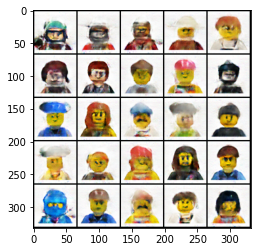

| Epoch: 291 |
| Epoch: 292 |
| Epoch: 293 |
| Epoch: 294 |
| Epoch: 295 | D_error: 0.035 | G_error: 6.087 | FID_score: 312.9032 | Time: 0m 17s


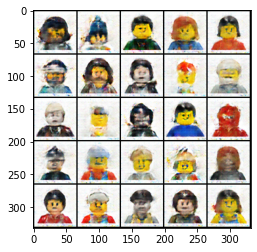

| Epoch: 296 |
| Epoch: 297 |
| Epoch: 298 |
| Epoch: 299 |
| Epoch: 300 | D_error: 0.541 | G_error: 1.683 | FID_score: 252.3746 | Time: 0m 17s


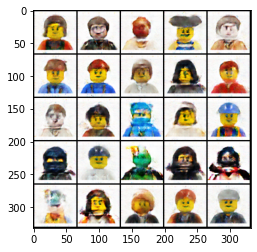

In [10]:
G_losses = []
D_losses = []
for epoch in range(0, N_EPOCHS+1):
    
    start_time = time.time()
    if epoch % 5 != 0:
        print('| Epoch: '+str(epoch)+' |')
    
    for _ in range(len(dataloader)):
        
        #=====================#
        # TRAIN DISCRIMINATOR #
        #=====================#
        
        #zero discriminator gradients
        D.zero_grad()
        
        #get batch of real images
        x, _ = next(iter(dataloader))
        
        #place images on GPU 
        x = x.to(device)
        
        #sample noise
        z = torch.randn(x.shape[0], LATENT_DIM, 1, 1).to(device)
        
        #generate images
        with torch.no_grad():
            generated_images = G(z)
        
        #put real images through discriminator
        pred_real = D(x)
        
        #how well does the discriminator detect real images?
        D_error_real = criterion(pred_real, real_labels)
        
        #put fake images through the discriminator
        #need to detach so don't backpropagate through generator
        pred_fake = D(generated_images.detach())
        
        #how well does the discriminator detect fake images?
        D_error_fake = criterion(pred_fake, fake_labels)
        
        #get discriminator error
        D_error = D_error_real + D_error_fake
        
        #backpropagate errors to get gradients
        D_error.backward()
        
        #use gradient to update discriminator parameters
        D_optimizer.step()
        
        #=================#
        # TRAIN GENERATOR #
        #=================#
        
        #zero generator gradients
        G.zero_grad()
        
        #sample noise
        z = torch.randn(x.shape[0], LATENT_DIM, 1, 1).to(device)
        
        #generate images
        generated_images = G(z)
        
        #put fake images through the discriminator
        pred_fake = D(generated_images)
        
        #how well does the generator fool the discriminator?
        G_error = criterion(pred_fake, real_labels)
        
        #backpropagate errors to get gradients
        G_error.backward()
        
        #use gradient to update generator parameters
        G_optimizer.step()
        
    # Save Losses for plotting later
    G_losses.append(G_error.item())
    D_losses.append(D_error.item())
    fretchet_dist=calculate_fretchet(x, generated_images, model)
        
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
    if (epoch % 5) == 0:
    
        #sample noise
        z = torch.randn(5*5, LATENT_DIM, 1, 1).to(device)
    
        #generate images
        with torch.no_grad():
            generated_images = G(z)
    
        print(f'| Epoch: {epoch:03} | D_error: {D_error.item():.03f} | G_error: {G_error.item():.03f} | FID_score: {fretchet_dist:.04f} | Time: {epoch_mins}m {epoch_secs}s')
        
        #save 25 images
        torchvision.utils.save_image(generated_images, 
                                     f'/content/output/epoch{epoch:03}.png', 
                                     nrow=5,
                                     normalize=True)
        
        #display images
        img = plt.imread(f'/content/output/epoch{epoch:03}.png')
        plt.imshow(img)
        plt.show()



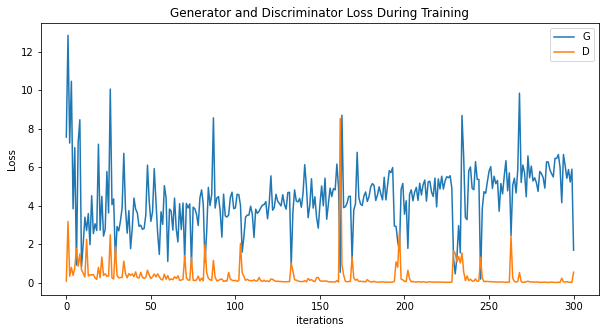

In [11]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()